# Quantum-Classical Parameter Mapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numba import njit
from itertools import product
from scipy.optimize import minimize
from scipy.linalg import kron

In this Jupyter notebook, we aim to numerically analyze the mapping of parameters between a QM Equilibrium Ising model and a dynamical classical Ising model. 

<center><img src="https://github.com/ringo333/QBM-code/blob/develop/Figures/Theory/Quantum%20Classical%20Mapping%20Diagram.drawio(2)(1).png?raw=true"/></center>

## Simulating the classical dynamics

First off, we aim to simulate the following dynamical system:

$W\left(s^{\prime} \mid s\right)=W(s \mid s) \delta_{s^{\prime}, s} + \sum_{i} g_{i}(s) \delta_{s^{\prime}, F_{i}[s]} +  \sum_{ij} g_{ij}(s) \delta_{s^{\prime}, F_{ij}[s]}$

In this formulation, $g_i$ and $g_{ij}$ represent the probabilities of single and double spin flips respectively, whereas $F_i[]$ acts as the flip operator, which inverts the spin 'i' of a given state 's'. The indices i and j in this context denote the specific bits of the spin state to be flipped. The additional parameter $w$ allows us to adjust the time-scales associated with the spin flips without impacting the steady-state distribution. Please note that this parameter matrix $w$ needs to be symmetric, for instance, $w_{12} = w_{21}$. This is because flipping bits 1 and 2 is equivalent to flipping bits 2 and 1.

We can express the explicit flip probabilities as:

$g_i(s)=\exp \left[-w_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$

$g_{ij}(s) = \exp \left(-w_{ij}+J_{ij} s_is_j - s_i \left[\sum_{i} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{i'} J_{jk'} s_{k'} + h_j \right] \right)$

The diagonal entries $W(s \mid s)$ are defined as $ 1 - \sum_{s'} W(s \mid s')$. In this context, the parameters $w$ establish the normalization of the self-transitions and should be selected such that $W(s \mid s) > 0$.

Using these dynamics, we can derive a transition matrix. Here, the row entries indicate the initial state of the system, while the column entries represent the target state. The matrix entries themselves correspond to the respective transition probabilities. Each row of the transition matrix is normalized. The spin states {-1,1} are mapped to binary {0,1}, with the leftmost bit corresponding to the first spin.

As an example, for a system with three spins, the explicit transition matrix could be presented as follows:

$$W = \begin{pmatrix}
W(000|000) & g_1(000) & g_2(000) & g_{12}(000) & g_3(000) & g_{13}(000) & g_{23}(000) & 0 \\
g_1(001) & W(001|001) & g_{12}(001) & g_2(001) & g_{13}(001) & g_3(001) & 0 & g_{23}(001) \\
g_2(010) & g_{12}(010) & W(010|010) & g_1(010) & g_{23}(010) & 0 & g_3(010) & g_{13}(010) \\
g_{12}(011) & g_2(011) & g_1(011) & W(011|011) & 0 & g_{23}(011) & g_{13}(011) & g_3(011) \\
g_3(100) & g_{13}(100) & g_{23}(100) & 0 & W(100|100) & g_1(100) & g_2(100) & g_{12}(100) \\
g_{13}(101) & g_3(101) & 0 & g_{23}(101) & g_1(101) & W(101|101) & g_{12}(101) & g_2(101) \\
g_{23}(110) & 0 & g_3(110) & g_{13}(110) & g_2(110) & g_{12}(110) & W(110|110) & g_1(110) \\
0 & g_{23}(111) & g_{13}(111) & g_3(111) & g_{12}(111) & g_2(111) & g_1(111) & W(111|111) \\
\end{pmatrix}$$



In [2]:
###  CONVERTING SPIN <-> BINARY FUNCTIONS
#----------------------------------------------------------------------
@njit
def index_to_spin_state(s_idx, N):
    """Convert an index to a spin state."""
    s = np.zeros((N,), dtype=np.int64)
    for i in range(N):
        # get the ith bit of s_idx.
        bit = (s_idx >> i) & 1
        # convert the bit to a spin (-1 or 1).
        s[N - 1 - i] = bit * 2 - 1
    return s

@njit
def spin_state_to_index(s):
    """Convert a spin state to an index."""
    N = len(s)
    s_idx = 0
    for i in range(N):
        # convert the spin to a bit (0 or 1).
        bit = (s[i] + 1) // 2
        # set the ith bit of s_idx.
        s_idx |= bit << (N - 1 - i)
    return s_idx

@njit
def bits_flipped_indices(s_idx, flip_index, N):
    """Return the indices of the bits that are flipped when going from s_idx to flip_index."""
    flipped_bits = s_idx ^ flip_index
    flipped_indices = []
    for k in range(N):
        if (flipped_bits & (1 << k)) != 0:
            flipped_indices.append(N - 1 - k)
    return flipped_indices

In [3]:
### AUXILARY SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def g_single(i, s, w, h, J):
    """Probability associated with a single spin flip"""
    sum_term = h[i]
    for j in range(len(s)):
        if i != j:
            sum_term += J[i, j] * s[j]
    return np.exp(-w[i, i] - s[i] * sum_term)

@njit
def g_double(i, j, s, w, h, J):
    """Probability associated with a double spin flip"""
    sum_term_i = h[i]
    for k in range(len(s)):
        if k != i:
            sum_term_i += J[i, k] * s[k]

    sum_term_j = h[j]
    for k in range(len(s)):
        if k != j:
            sum_term_j += J[j, k] * s[k]

    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j)

@njit
def choice(probabilities):
    """A workaround for np.random.choice, which is unsupported by numba"""
    cumulative_distribution = np.cumsum(probabilities)
    return np.searchsorted(cumulative_distribution, np.random.random(), side ="right")

In [4]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def compute_transition_matrix(w, h, J):
    """Computes the transition matrix for the given parameters."""
    N = len(h)  # number of spins in the lattice
    transition_matrix = np.zeros((2**N, 2**N))

    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        flip_probs = np.zeros((2**N))  # Initialize with zeros

        for i in range(N):
            flip_index = s_idx ^ (1 << i)
            i_flipped = bits_flipped_indices(s_idx, flip_index, N)[0]
            flip_probs[flip_index] = g_single(i_flipped, s, w, h, J)  # single flip probabilities

        for i in range(N):
            for j in range(i+1, N):
                flip_index = s_idx ^ (1 << i) ^ (1 << j)
                i_flipped, j_flipped = bits_flipped_indices(s_idx, flip_index, N)
                flip_probs[flip_index] = g_double(i_flipped, j_flipped, s, w, h, J)  # double flip probabilities

        # add the no-flip probability and store the flipping probabilities
        no_flip_prob = 1 - sum(flip_probs)
        flip_probs[s_idx] = no_flip_prob
        transition_matrix[s_idx] = flip_probs

    return transition_matrix

@njit
def spin_flip(s, transition_matrix):
    """
    Flipping algorithm, uses precomputed transition matrix.
    """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    s_idx = spin_state_to_index(s)

    # get probabilities from transition matrix
    flip_probs = transition_matrix[s_idx]

    # randomly choose a spin flip according to its probability of occurring
    idx = choice(flip_probs)

    # apply the chosen spin flip
    flipped_indices = bits_flipped_indices(s_idx, idx, N)
    
    if len(flipped_indices) == 0:  # no flip
        pass
    if len(flipped_indices) == 1:  # single flip
        i = flipped_indices[0]
        s[i] *= -1
    elif len(flipped_indices) == 2:  # double flip
        i, j = flipped_indices
        s[i] *= -1
        s[j] *= -1

    return s

@njit
def simulate_dynamics(W, steps, N):
    """Simulates the dynamics of the system for the given number of steps."""
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(N)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, N), dtype=np.int64)

    for t in range(steps):
        s = spin_flip(s, W)
        trajectory[t] = s

    return trajectory

@njit
def find_min_w(w, h, J, step_size, no_flip_prob):
    """Finds the smallest offset to add to the w parameter such that diagonal elements of W become at least no_flip_prob"""
    min_scalar = 0
    while True:
        # update w with the current scalar value
        new_w = w + np.ones(w.shape) * min_scalar
        
        # calculate the transition matrix
        transition_matrix = compute_transition_matrix(new_w, h, J)
        
        # calculate the self-transition probabilities for each state
        self_probs = np.diag(transition_matrix)

        # check if the self-transition probabilities are all at least no_flip_prob
        if np.all(self_probs >= no_flip_prob):
            break

        # if the condition is not met, increase the scalar value and try again
        min_scalar += step_size

    return new_w


In [5]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------

def plot_combined_dynamics(trajectory, N):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [(''.join(['0' if spin == -1 else '1' for spin in s])) for s in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.step(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(N):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.step(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()


### Testing the classical dynamics
**We now effectively can simulate the dynamics given the classical parameters $w$, $J$ and $h$. Let's do some checks.**  
We check if the rows sum of W sum up to 1, there are no negative probabilities, if the conversion between spins states and indices are correct and if the steady-state of W corresponds to the Boltzmann distribution:

In [6]:
### TEST FUNCTIONS
#----------------------------------------------------------------------
def test_transition_matrix(W):
    """Test that the sum of the probabilities in each row of the transition matrix is 1 and there are no negative elements."""
    for row in W:
        assert np.isclose(np.sum(row), 1), "Row sums to " + str(np.sum(row))
        assert np.all(row >= 0), "Negative probability in row " + str(row)

def test_spin_index_conversion(N):
    """Test that the conversion functions between spin states and indices are correct."""
    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        assert spin_state_to_index(s) == s_idx, "Conversion failed for index " + str(s_idx)

def energy(s, J, h):
    """
    Compute the energy of the system in a particular spin state.
    """
    s = s.astype(np.float64)                              # convert the spin configuratio to float64 for numba
    pairwise_energy = np.dot(s, np.dot(J, s))
    local_field_energy = h * s                            # simple multiplication for scalar-array operation
    return -pairwise_energy - np.sum(local_field_energy)  # sum over local field energy

def boltzmann_distribution(J, h):
    N = len(h)
    all_states = np.array([index_to_spin_state(s_idx, N) for s_idx in range(2**N)])
    energies = np.array([energy(state, J, h) for state in all_states])
    probabilities = np.exp(-energies)
    Z = np.sum(probabilities)
    return probabilities / Z

def plot_convergence_to_boltzmann(J, h, trajectory):
    n_spins = len(h)
    boltzmann_probs = boltzmann_distribution(J, h).flatten()

    # count the occurrences of each unique spin state in the trajectory
    state_counts = {}
    for state in trajectory:
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            state_counts[state_tuple] += 1
        else:
            state_counts[state_tuple] = 1

    # calculate the empirical probabilities from the trajectory
    empirical_probs = np.zeros(2**n_spins)
    for idx, state in enumerate(np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])):
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            empirical_probs[idx] = state_counts[state_tuple] / len(trajectory)

    # plot the Boltzmann probabilities and the empirical probabilities
    state_labels = [spin_state_to_index(state) for state in np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])]
    x = np.arange(len(state_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 3))
    rects1 = ax.bar(x - width / 2, boltzmann_probs, width, label='Boltzmann', color='SteelBlue', alpha=0.8)
    rects2 = ax.bar(x + width / 2, empirical_probs, width, label='Simulation', color='Coral', alpha=0.8)

    ax.set_ylabel('Probability')
    ax.set_xlabel('Spin states')
    ax.set_title('Boltzmann vs Simulation Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels(state_labels)
    ax.legend()

    plt.show()

def test_boltzmann_convergence(W, J, h, tolerance=1e-2):
    """
    Test if the steady state probabilities obtained from the transition matrix
    match the Boltzmann distribution probabilities. Also, plot the Boltzmann probabilities
    and the empirical probabilities calculated from the trajectory.
    """
    # compute the Boltzmann distribution probabilities
    boltzmann_probs = boltzmann_distribution(J, h).flatten()
    
    # set print options
    np.set_printoptions(precision=2, suppress=True)
    # print(f"Collumn normalized notation:")
    # print(f"\n Transition matrix W: \n{W.T}")

    # compute the eigenvalues and eigenvectors of the transition matrix
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing
    
    # get the eigenvector corresponding to the largest eigenvalue
    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])

    # print(f"\n Eigenvalues of W: \n {eigenvalues}")
    # print(f"\n Eigenvectors of W: \n {eigenvectors}")
    # print(f"\n Steady state p of W[non-normalized]: {p}")
    
    # normalize the eigenvector to get steady state probabilities
    p = p / np.sum(p)

    print(f"\n Steady state p of W[normalized]: {p}")
    print(f"Boltzmann distribution probabilities: {boltzmann_probs}")

    # plot the convergence to the Boltzmann distribution
    trajectory = simulate_dynamics(W, 2**22, len(h))
    plot_convergence_to_boltzmann(J, h, trajectory)
    
    # check if the two probability distributions are close
    assert np.allclose(p, boltzmann_probs, atol=tolerance), "Boltzmann convergence test failed"


 Steady state p of W[normalized]: [0.49 0.01 0.   0.   0.   0.   0.01 0.49]
Boltzmann distribution probabilities: [0.5 0.  0.  0.  0.  0.  0.  0.5]


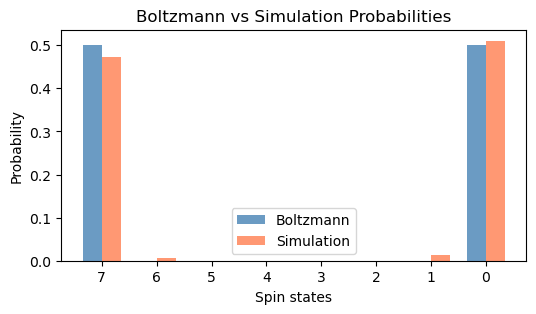

All tests passed!


In [7]:
# initialize the tests
N = 3
w = np.array([[1.,2.,4.],
              [2.,4.,1.],
              [4.,1.,4.]])
J = np.array([[0,4,2],
              [4,0,0],
              [2,0,0]])
h = np.array([0, 0, 0])

# make sure w are large enough for normalized probabilities
w = find_min_w(w, h, J, step_size = 1e-3, no_flip_prob = 0)

#compute W and run the tests
W = compute_transition_matrix(w, h, J)

test_transition_matrix(W)
test_spin_index_conversion(N)
test_boltzmann_convergence(W, J, h)
print("All tests passed!")

## Implementation of the Boltzmann Machine

Our next goal is to be able to infer the parameters $w$, $J$ and $h$ from a time series data of our system similiar to the left graph above this cell. Firstly, we need to construct an empirical transition matrix, $W^{emp}$, from the time series data. This matrix captures the probabilities of transitioning between different states, as observed in the data.

In [8]:
@njit
def infer_transition_matrix(trajectory):
    """Infers the transition matrix from a time series of the states of the system"""
    N = trajectory.shape[1]
    n_states = 2**N

    # initialize the transition matrix
    transition_matrix = np.zeros((n_states, n_states))

    # count the transitions from each state to each other state
    for i in range(len(trajectory) - 1):
        # Convert the spin states to indices
        from_idx = spin_state_to_index(trajectory[i])
        to_idx = spin_state_to_index(trajectory[i+1])

        # Update the transition matrix
        transition_matrix[from_idx, to_idx] += 1

    # Normalize each row of the transition matrix
    for i in range(n_states):
        row_sum = transition_matrix[i].sum()
        if row_sum > 0:
            transition_matrix[i] /= row_sum

    return transition_matrix

##### **To check if this function works, we can see if in the limit of long trajectories, the empirical transition matrix converges to the exactly computed transition matrix**

In [9]:
def test_infer_transition_matrix(w, h, J, N, steps):
    """Test that the empirical transition matrix converges to the model transition matrix for long trajectories."""
    # Compute the model transition matrix
    model_W = compute_transition_matrix(w, h, J)

    # Simulate a trajectory of the system
    trajectory = simulate_dynamics(model_W, steps, N)

    # Infer the empirical transition matrix from the trajectory
    empirical_W = infer_transition_matrix(trajectory)
    
    # Check that the empirical transition matrix is close to the model transition matrix
    assert np.allclose(empirical_W, model_W, atol=1e-2), "Empirical transition matrix does not match model transition matrix"

# Run the test
N = 3
w = np.random.rand(N, N)
h = np.random.rand(N)
J = np.random.rand(N, N)

#make sure w are large enough for normalized probabilities
w = find_min_w(w, h, J, step_size = 1e-3, no_flip_prob = 0)

test_infer_transition_matrix(w, h, J, N, steps=2**22)

print("Test passed!")

Test passed!


Now we will need to be able to infer the classical parameters from the empirical transition matrix. This process requires more thought. We can always obtain the equilibrium distribution p(s) from the transition matrix by finding the eigenvector corresponding to the eigenvalue 1. From p(s), we can determine the parameters J and h using a classical Boltzmann machine to model the equilibrium distribution. We can obtain the clamped statistics from the transition matrix as follows: 
$$ \langle s_i \rangle _c = \sum_s s_i p(s) $$
$$ \langle s_i s_j \rangle _c = \sum_s s_i s_j p(s)$$

The clamped statistics can be used in the Boltzmann machine. 

In [10]:
###  BOLTZMANN MACHINE AUXILARY FUNCTIONS
#----------------------------------------------------------------------
def all_possible_configs(N):
    '''Generates a 2^N by N matrix with all possible configurations of a binary spin system of size N'''
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@njit
def calcEnergy(config: np.ndarray, J: np.ndarray, h: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_float = config.astype(np.float64)  # convert config to float
    energy = -np.dot(config_float.T, np.dot(J, config_float)) / 2 - np.dot(h, config_float)
    return energy

@njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@njit
def calcCorr(config: np.ndarray) -> np.ndarray: 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@njit
def log_likelihood(p, J, h, configs):
    """Calculates the log-likelihood of the system under the Boltzmann distribution."""
    Z = 0
    for config in configs:
        Ene = calcEnergy(config, J, h)
        Z += np.exp(-Ene)
    logZ = np.log(Z)

    log_likelihood = 0
    for i, config in enumerate(configs):
        Ene = calcEnergy(config, J, h)
        log_likelihood += p[i] * (-Ene - logZ)

    return log_likelihood

In [11]:
###  BOLTZMANN MACHINE FUNCTIONS
#----------------------------------------------------------------------
@njit
def ising_solve_exact_simplified(N, J, h, configs):    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    beta = 1.0
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,J,h)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this 
                                                      #  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj

@njit
def classical_boltzmann_machine(p, N, configs, maxiter, learning_rate, tol=1e-8):
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
    and the inferred weight matrix'''
    J_assym = 2.0 * np.random.random((N, N)) - 1.0   # random initial values between -1 and 1
    J = (J_assym+ J_assym.T)/2                       # symmetrize the random matrix 
    np.fill_diagonal(J, 0)                           # set diagonal of J to 0 to ensure detailed balance
    h = 2.0 * np.random.random(N) - 1.0              # random initial values between -1 and 1

    # compute the expected spin values
    Ci_clamp = np.dot(p, configs)

    # compute the expected spin-spin correlations
    CiCj_clamp = configs.T @ np.diag(p) @ configs
        
    #  initialize gradient ascent values  
    it    = 0
    delta_J = np.inf
    delta_h = np.inf
    # old_log_likelihood = -np.inf

    # initialize lists to store the values of the parameters and the log-likelihood at each iteration
    J_values = []
    h_values = []
    log_likelihood_values = []
    
    while (it < maxiter and (delta_J > tol or delta_h > tol)):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        Ci_free, CiCj_free = ising_solve_exact_simplified(N, J, h, configs) 

        # compute the updates for J and h
        delta_J = learning_rate * (CiCj_clamp - CiCj_free)
        delta_h = learning_rate * (Ci_clamp   - Ci_free)
            
        h     = h + delta_h               #  update weight matrix based on statistics  
        J     = J + delta_J
        
        # compute the magnitude of the updates
        delta_J = np.linalg.norm(delta_J)
        delta_h = np.linalg.norm(delta_h)

        # calculate the log-likelihood and check for convergence
        new_log_likelihood = log_likelihood(p, J, h, configs)
        # if np.abs(new_log_likelihood - old_log_likelihood) < tol:
        #     break
        # old_log_likelihood = new_log_elikelihood

        # store the current values of the parameters and the log-likelihood
        J_values.append(J)
        h_values.append(h)
        log_likelihood_values.append(new_log_likelihood)
        
    return J, h, J_values, h_values, log_likelihood_values

In [12]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot_convergence(J_values, h_values, log_likelihood_values, title='Convergence Plots', size=10):
    '''Plots the convergence of the parameters and the log-likelihood.'''
    it = len(J_values)
    its = np.arange(1, it+1, 1)
    its_diff = np.arange(1, it, 1)

    J_diff = np.diff(J_values, axis=0)
    h_diff = np.diff(h_values, axis=0)

    J_max = np.linalg.norm(J_diff, axis=(1,2))
    h_max = np.linalg.norm(h_diff, axis=1)

    fig = plt.figure(figsize=(25, 6));    #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    ax1 = fig.add_subplot(1, 3, 1)
    plot_scatter(ax1, its_diff , J_max, "Iterations", r"$ (\Delta h)_{max}$", "Coral", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(1, 3, 2)
    plot_scatter(ax2, its_diff , h_max, "Iterations", r"$ (\Delta J)_{max}$ ", "HotPink", size)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, log_likelihood_values, s=size, marker='o', color="ForestGreen")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')



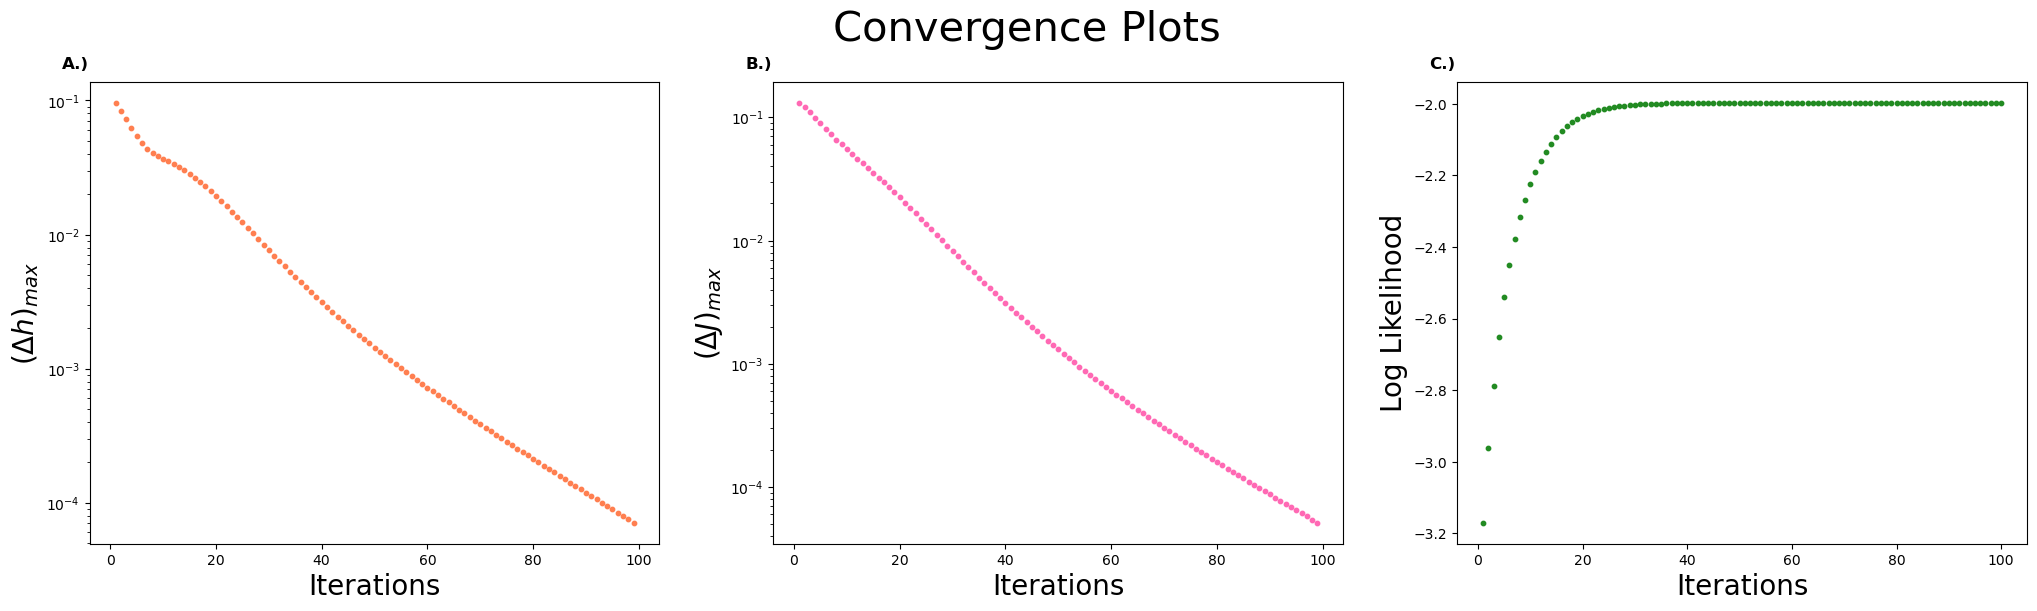

In [13]:
# Generate some random data
N = 3
configs = all_possible_configs(N)
p = np.random.rand(2**N)
p /= np.sum(p)  # normalize to make it a valid probability distribution

# Run the Boltzmann machine
J, h, J_values, h_values, log_likelihood_values = classical_boltzmann_machine(p, N, configs, maxiter=100, learning_rate=0.1)

# Plot the convergence
plot_convergence(J_values, h_values, log_likelihood_values)


**Now we check if the Boltzmann machine can accurately retrieve the parameters from a predefined distribution. We generate a known set of parameters and then inspect if the Boltzmann machine can successfully recover these parameters. Please remember that the diagonal of J should be devoid of any entries, such that detailed balance is adhered to.**

In [14]:
def test_boltzmann_machine():
    # Define the known parameters
    N = 3
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float64)
    known_h = np.array([1, -1, 1], dtype=np.float64)

    # Generate the known distribution
    configs = all_possible_configs(N)
    p = np.zeros(2**N)
    for i, config in enumerate(configs):
        config_float = config.astype(np.float64)  # convert config to float
        energy = calcEnergy(config_float, known_J, known_h)  # calculate energy
        p[i] = np.exp(-energy)  # calculate probability
    p /= np.sum(p)  # normalize

    # Run the Boltzmann machine
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter=2**16, learning_rate=0.1)

    # Check that the recovered parameters are close to the known parameters
    assert np.allclose(J, known_J, atol=0.1), "Recovered J does not match known J"
    assert np.allclose(h, known_h, atol=0.1), "Recovered h does not match known h"

test_boltzmann_machine()
print("Test passed!")


Test passed!


**Check if the BM still works if we first generate a transition matrix with the parameters and then infer J and h. Also checks if w parameter does not affect the equilibrium distribution p(s):**

In [15]:
def test_params_to_W_to_BM():
    # define the known parameters
    N = 3
    known_w = np.array([[1,2,4],[3,2,3],[5,2,3]])
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float64)
    known_h = np.array([1, -1, 1], dtype=np.float64)

    # generate the transition matrix
    W = compute_transition_matrix(known_w, known_h, known_J)

    # infer the equilibrium distribution p from W
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing
    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter=2**16, learning_rate=0.1)

    # Check that the recovered parameters are close to the known parameters
    assert np.allclose(J, known_J, atol=0.1), "Recovered J does not match known J"
    assert np.allclose(h, known_h, atol=0.1), "Recovered h does not match known h"

test_params_to_W_to_BM()
print("Test passed!")


Test passed!


Once we've obtained J and h, we can find the parameters w by rewriting the formula for the flipping probabilities:

 $$w_{ii}=\exp \left[-W^{emp}_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$$

$$w_{ij}(s) = \exp \left(-W^{emp}_{ij}+J_{ij} s_is_j - s_i \left[\sum_{i} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{i'} J_{jk'} s_{k'} + h_j \right] \right)$$

where $W^{emp}$ are the empirically found transition probabilities.

In [16]:
def compute_w(W, J, h):
    """Computes the parameters w from the flip probabilities, J, h, and the spin states."""
    # Initialize w with zeros
    N = len(h)
    w = np.zeros((N, N))
    from_idx = 0 # arbitarly choose first row of W
    s = index_to_spin_state(from_idx, N)

    # sum over row entries of W, to find all possible w
    for to_idx in range(1,2**N,1):
        # calculate w_ii
        flipped_indices = bits_flipped_indices(from_idx, to_idx, N)
        if len(flipped_indices) == 0:  # no flip
            pass

        if len(flipped_indices) == 1:  # single flip, compute wii
            i = flipped_indices[0]
            sum_term = h[i] + np.sum(J[i, :] * s)
            w[i, i] = -np.log(W[from_idx,to_idx]) - s[i] * sum_term

        elif len(flipped_indices) == 2:  # double flip, compute wij
            i, j = flipped_indices
            sum_term_i = h[i] + np.sum(J[i, :] * s)
            sum_term_j = h[j] + np.sum(J[j, :] * s)
            w[i, j] = -np.log(W[from_idx,to_idx]) + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j
            w[j, i] = w[i, j]  # w is symmetric

    return w


def infer_parameters(W, N, maxiter=2**20, learning_rate=0.1):
    """Infers the parameters w, h, J from a given transition matrix."""
    # infer the equilibrium distribution p from W
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing
    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter, learning_rate)

    w = compute_w(W, J, h)

    return w, h, J


**Check if we can fully recover the parameters w, h and J from a oracle transition matrix $W$:**

In [17]:
def test_infer_parameters():
    # Define the known parameters
    N = 3
    known_w = np.array([[1,3,4],[3,2,3],[4,3,5]], dtype = np.float64)
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float64)
    known_h = np.array([1, -1, 1], dtype=np.float64)

    # generate the transition matrix
    W = compute_transition_matrix(known_w, known_h, known_J)

    # Infer the parameters from the transition matrix
    w, h, J = infer_parameters(W, N)

    # Check that the inferred parameters are close to the known parameters
    assert np.allclose(w, known_w, atol=0.1), "Inferred w does not match known w"
    assert np.allclose(h, known_h, atol=0.1), "Inferred h does not match known h"
    assert np.allclose(J, known_J, atol=0.1), "Inferred J does not match known J"

test_infer_parameters()
print("Test passed!")


Test passed!


## Quantum Parameters to a Density Matrix

We want to make a similar mapping between transition probabilities and Hamiltonian parameters in the quantum domain. There are a few key differences in the quantum formalism:
- The transition matrix $W$ is replaced by a density matrix $\rho$ 
- The binary spins $s_i$ are replaced by Pauli spin 1/2 operators $\sigma_i^k$

We can generate a density matrix as follows:
$$ \rho = \frac{e^{\hat{H}}}{Z} $$

Note that this involves taking the exponential of a _matrix_. Matrix exponentials (or logarithms) can be done using Hamiltonian eigendecomposition:
$$ \hat{H} \rarr E, \ket{E} $$
with $E$ and  $\ket{E}$  the eigenvalues and eigenvectors of $\hat{H}$, respectively. 
$$ \hat{H} = \sum_E E \ \ket{E} \bra{E} $$
using that 
$$f(\hat{H}) = \sum_E f(E) \ket{E} \bra{E} $$
we can compute the density matrix using
$$ \rho = \sum_E p_E \ket{E} \bra{E}$$

With  and $p_E = \frac{e^E}{Z}$ the eigenvalues.

In [18]:
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`. Same structure as expmat.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

## Implementation of the Quantum Boltzmann Machine

We use a n-qubit system, where the goal is to learn the parameters of the Ising Hamiltonian:

$H = \sum_{i} \sum_{j}\sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_i^k \otimes \sigma_j^{k'} + \sum_{i}\sum_{k} h^k_i \sigma_{i}^k$

where $w_{ij}^{kk'}$ is the coupling strength, $h_i$ are the local fields, and $\sigma_i^k$ are the Pauli operators. For the Pauli matrices, indexes $k=1,2,3$ correspond to $x,y,z$, index $k=0$ to the identity. The explicit Hamiltonian is written as:

$H = \sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_0^k \otimes \sigma_1^{k'} + h^k_0 \sigma_0^k \otimes \sigma_1^0 + h^{k'}_1 \sigma_0^0 \otimes \sigma_1^{k'}$


### Defining the interaction matrices and their weights

In [19]:
# define the Pauli matrices globally
PAULI_I = np.array([[1, 0], [0, 1]], dtype=np.complex128)
PAULI_X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
PAULI_Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
PAULI_Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# create an array of Pauli matrices and their labels
PAULI_MATRICES = np.array([PAULI_I, PAULI_X, PAULI_Y, PAULI_Z], dtype=np.complex128)
PAULI_LABELS = ['I', 'X', 'Y', 'Z']

def tensor_product(matrices):
    """Compute the tensor product of a list of matrices."""
    result = matrices[0]
    # iterate over each matrix in the list starting from the second one
    for matrix in matrices[1:]:
        result = kron(result, matrix)
    return result
 
def generate_interaction_matrices(num_qubits):
    """Constructs the tensor product of Pauli matrices for each qubit pair."""
    num_combinations = 4 ** num_qubits # total number of combinations of Pauli matrices for num_qubits
    interaction_matrices = np.empty((num_combinations, 2 ** num_qubits, 2 ** num_qubits), dtype=np.complex128) 
    interaction_labels = np.empty((num_combinations, num_qubits), dtype=object)

    # initialize an empty dictionary to store the weights associated with each interaction matrix
    interaction_weights = {}

    # enumerate over all possible combinations of Pauli matrices for num_qubits
    for idx, matrix_indices in enumerate(product(range(4), repeat=num_qubits)):
        # select the corresponding Pauli matrices for the current combination
        matrices = PAULI_MATRICES[list(matrix_indices)]
        # compute the tensor product of the selected matrices
        interaction_matrix = tensor_product(matrices)

        # store the computed tensor product matrix and its corresponding labe
        interaction_matrices[idx] = interaction_matrix
        label_tuple = tuple(PAULI_LABELS[i] for i in matrix_indices)
        interaction_labels[idx] = label_tuple

        # initialize the weight associated with this interaction matrix
        # by default, it is set to None. You can change it later.
        interaction_weights[label_tuple] = None

    return interaction_matrices, interaction_labels, interaction_weights

**"interaction_matrices" is an array that holds the tensor product of Pauli matrices for each possible combination of qubits. It is ordered lexicographically. For a 3-qubit system the first entries look like this:**

In [20]:
def print_matrix(matrix):
    for row in matrix:
        print('[', end='')
        for elem in row:
            real = elem.real
            imag = elem.imag
            if abs(real) < 1e-10 and abs(imag) < 1e-10:
                print("0", end=' ')
            elif abs(real) < 1e-10:
                print(f"{imag:.0f}j", end=' ')
            elif abs(imag) < 1e-10:
                print(f"{real:.0f}", end=' ')
            else:
                print(f"{real:.0f}+{imag:.2f}j", end=' ')
        print(']')
    print()
    

interactions, interaction_labels, interaction_weights = generate_interaction_matrices(3)

for i, label in enumerate(interaction_labels[:10]):
    print(label)
    # print_matrix(interactions[i])  #uncomment to see the associated matrix with each label

['I' 'I' 'I']
['I' 'I' 'X']
['I' 'I' 'Y']
['I' 'I' 'Z']
['I' 'X' 'I']
['I' 'X' 'X']
['I' 'X' 'Y']
['I' 'X' 'Z']
['I' 'Y' 'I']
['I' 'Y' 'X']


**This lexiographic ordering is not very intuitive to index with weights. Because the amount of interaction matrices scales with $4^N$, it is non-trivial to index the weights, despite what kind of ordering we use. We can circumvent this problem by using a dictionary structure for the weights. We can then set the weights using the the interaction labels as follows:**

In [21]:
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(3)

interaction_weights[('I', 'I', 'I')] = .1
interaction_weights[('I', 'I', 'X')] = .2
interaction_weights[('I', 'I', 'Y')] = .3
interaction_weights[('I', 'I', 'Z')] = .4
interaction_weights[('I', 'X', 'I')] = .5
interaction_weights[('I', 'X', 'X')] = .6
interaction_weights[('I', 'X', 'Z')] = .7
#interactions that are not defined, are automatically set to 0

**Let's test if this structure works as intended. We print the weight and interaction matrix associated with $\sigma_{23}^{xy}$ and $\sigma_{123}^{zxy}$:**

In [22]:
def test_interaction(label_tuple, interaction_matrices, interaction_labels, interaction_weights):
    """
    Given an interaction label, prints the associated interaction matrix and the associated weight.
    """
    # find the index of the label tuple in interaction_labels
    idx = np.where(np.all(interaction_labels == label_tuple, axis=1))[0][0]

    # fetch the corresponding interaction matrix
    interaction_matrix = interaction_matrices[idx]

    # fetch the corresponding weight
    weight = interaction_weights.get(label_tuple, None)

    print("Interaction Matrix for {}: \n".format(label_tuple))
    print_matrix(interaction_matrix)
    print("Associated weight: ", weight)

test_interaction(('I', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)
test_interaction(('Z', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)

Interaction Matrix for ('I', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 -1j ]
[0 0 0 0 0 0 1j 0 ]
[0 0 0 0 0 -1j 0 0 ]
[0 0 0 0 1j 0 0 0 ]

Associated weight:  0.7
Interaction Matrix for ('Z', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 1j ]
[0 0 0 0 0 0 -1j 0 ]
[0 0 0 0 0 1j 0 0 ]
[0 0 0 0 -1j 0 0 0 ]

Associated weight:  None


**If we want our code to be compatible with numba NJIT compilation, we can't use dictionary formatting for our weights. However, we want to maintain the dictionary structure because it makes it significantly easier to associate a weight with each interaction matrix than using array indexing (which is varying for different amount of qubits). We thus need a way to convert a weights dictionary to 1D numpy array and vice versa:**

In [23]:
def weights_dict_to_array(interaction_labels, interaction_weights):
    """
    Converts the interaction_weights dictionary to a numpy array based on the order of interaction_labels.
    """
    weights_array = np.array([interaction_weights[tuple(label)] if interaction_weights[tuple(label)] is not None else 0 for label in interaction_labels])
    return weights_array

def weights_array_to_dict(interaction_labels, weights_array):
    """
    Converts a numpy array to an interaction_weights dictionary based on the order of interaction_labels.
    """
    interaction_weights = {tuple(label): weights_array[i] for i, label in enumerate(interaction_labels)}
    return interaction_weights

def generate_random_parameter_matrix(random_seed, num_qubits, interaction_labels):
    """
    Generates a random parameter array for the random seed value random_seed.
    Interactions containing more than 2-body interactions are set to zero.
    """
    np.random.seed(random_seed)  # set the random seed value
    num_params = 4**num_qubits   # calculate the number of parameters for the weight matrix
    w_array = np.random.rand(num_params)  # generate a random parameter array of size num_params

    # iterate over the interaction labels
    for i, label_tuple in enumerate(interaction_labels):
        # count the number of 'I' in the current label tuple
        num_I = np.count_nonzero(label_tuple == 'I')
        # if there are more than 2 'I', set the corresponding weight to 0
        if num_I < num_qubits - 2:
            w_array[i] = 0

    w_array[0] = 0 # -log(Z) = 0
    return w_array

**Let's test if these functions work as intended. We generate a random weight matrix with only up to 2-body interactions allowed and translate it to a dictionary structure and back**

In [24]:
# generate random weights array
random_seed = 666
num_qubits = 2
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)
w_random = generate_random_parameter_matrix(random_seed, num_qubits, interaction_labels)
print("Initial weights array: \n", w_random)

# numpy array to weights dictionary
interaction_weights = weights_array_to_dict(interaction_labels, w_random)
print("Weights dictionary:")
for interaction_label, interaction_weight in interaction_weights.items():
    print(interaction_label, format(interaction_weight, ".2f"))

# weights dictionary to numpy array
weights_array = weights_dict_to_array(interaction_labels, interaction_weights) 
print("Recovered weights array: \n ", weights_array)

Initial weights array: 
 [0.   0.84 0.68 0.73 0.95 0.01 0.41 0.05 0.1  0.51 0.2  0.74 0.19 0.7
 0.29 0.77]
Weights dictionary:
('I', 'I') 0.00
('I', 'X') 0.84
('I', 'Y') 0.68
('I', 'Z') 0.73
('X', 'I') 0.95
('X', 'X') 0.01
('X', 'Y') 0.41
('X', 'Z') 0.05
('Y', 'I') 0.10
('Y', 'X') 0.51
('Y', 'Y') 0.20
('Y', 'Z') 0.74
('Z', 'I') 0.19
('Z', 'X') 0.70
('Z', 'Y') 0.29
('Z', 'Z') 0.77
Recovered weights array: 
  [0.   0.84 0.68 0.73 0.95 0.01 0.41 0.05 0.1  0.51 0.2  0.74 0.19 0.7
 0.29 0.77]


### Implementing the QBM

Now that we can properly generate the interaction matrices and associate a weight with them, we can build the quantum boltzmann machine:

In [25]:
###QBM AUXILLARY FUNCTIONS
#----------------------------------------------------------------------------------------------
@njit
def hamiltonian_n_qubits(interaction_weights, interaction_matrices):
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    num_qubits = int(np.log2(interaction_matrices.shape[1]))
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(len(interaction_weights)):
        H += interaction_weights[i] * interaction_matrices[i]

    return H

@njit
def rho_model(interaction_weights, interaction_matrices):
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(interaction_weights, interaction_matrices)  # get Hamiltonian matrix
    rho = expmat(H)                                        # definition of rho
    Z = np.real(np.trace(rho))                             # get Z
    rho /= Z                                               # normalize such that Tr[rho] = 1
    return rho 

@njit
def observables(rho, interaction_matrices):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interaction_matrices), dtype=np.complex128)
    rho_contig = np.ascontiguousarray(rho)

    for i, interaction_matrix in enumerate(interaction_matrices):   
        interaction_matrix_contig = np.ascontiguousarray(interaction_matrix)
        obs[i] = np.real(np.trace(np.dot(rho_contig, interaction_matrix_contig)))
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def QM_likelihood(eta,rho):
    """
    Calculates the quantum Likelihood of the distribution
    """
    return -np.real(np.trace(eta @ logmat(rho)))

Test is the density matrix calculated from the QM hamiltonian is valid:

In [34]:
# generate a density matrix
num_qubits = 2
interaction_matrices,interaction_labels,_ = generate_interaction_matrices(num_qubits)

np.random.seed(6)
test_w_qm = np.random.randint(0, 10, (16))

rho = rho_model(test_w_qm, interaction_matrices)

Now build the actual QBM

In [26]:
@njit
def quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, w_eta=None, eta=None):
    """
    Train the model to fit the target distribution eta.
    """

    # compute target density matrix using ED if oracle w_eta is provided, otherwise use provided eta
    if eta is None:
        eta = rho_model(w_eta, interaction_matrices)
        
    obs_clamped = observables(eta, interaction_matrices)  # get clamped QM statistics

    w = w_initial.copy()  # get initial weights for free QM statistics
    rho = rho_model(w, interaction_matrices)  # generate the density matrix rho for the initial weights
    obs_model = observables(rho, interaction_matrices)  # get free QM statistics

    it = 0  # initialize gradient ascent loop
    diff = np.inf
    W_list, lk_list, kl_list = np.zeros(maxiter), np.zeros(maxiter), np.zeros(maxiter)  # initialize values to store

    while diff > tolerance and it < maxiter:
        rho = rho_model(w, interaction_matrices)  # get free QM statistics
        obs_model = observables(rho, interaction_matrices)
        w_previous = w.copy()
        w += learning_rate * np.real(obs_clamped - obs_model)  # Update weights

        if w_eta is None:
            W_diff = np.max(np.abs(w - w_previous))
            W_list[it] = W_diff

        elif w_eta is not None:
            Wmax = np.max(np.abs(w-w_eta))
            W_list[it] = Wmax                  

        diff = np.max(np.abs(obs_model - obs_clamped))  # evaluate differences in clamped and model statistics

        lk_list[it] = QM_likelihood(eta, rho)
        kl_list[it] = KL_divergence(eta, rho)
        it += 1

    return w, lk_list, kl_list, W_list, it


In [27]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot(it, Wmax, kl, lk, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(its, Wmax[:it], s=size, marker='o', color="Coral")
    ax1.set_xlabel("Iterations", fontsize=20)
    ax1.set_ylabel(r"$ (\Delta w)_{max}$", fontsize=20)
    ax1.set_yscale('log')
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(its, kl[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.set_yscale('log')
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, lk[:it], s=size, marker='o', color="HotPink")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.set_yscale('log')
    # ax3.set_ylim([0.482015, 0.482030])
    ax3.text(0, 1.0, 'B.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

### Check for 3-qubit system

We can now check if the QBM is capable of recovering the QM parameters from a density matrix. We generate a target density matrix eta from a random oracle weight matrix. We then check if the QBM can recover this oracle weight matrix.

Oracle Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54 0.04 0.47 0.89 0.48 0.41 0.   0.   0.   0.4  0.   0.   0.
 0.63 0.   0.   0.   0.14 0.17 0.22 0.09 0.05 0.   0.   0.   0.61 0.
 0.   0.   0.64 0.   0.   0.   0.97 0.47 0.41 0.79 0.37 0.   0.   0.
 0.15 0.   0.   0.   0.06 0.   0.   0.  ]
QBM Recovered Weights: 
 [ 0.    0.05  0.94  0.69  0.58  0.14  0.95  0.34  0.62  0.45  0.24  0.03
  0.15  0.81  0.65  0.54  0.04  0.47  0.89  0.48  0.41  0.    0.   -0.
  0.4  -0.    0.    0.    0.63 -0.   -0.   -0.    0.14  0.17  0.22  0.09
  0.05 -0.    0.    0.    0.61 -0.    0.    0.    0.64 -0.    0.    0.
  0.97  0.47  0.41  0.79  0.37 -0.    0.    0.    0.15  0.   -0.    0.
  0.06  0.    0.   -0.  ]


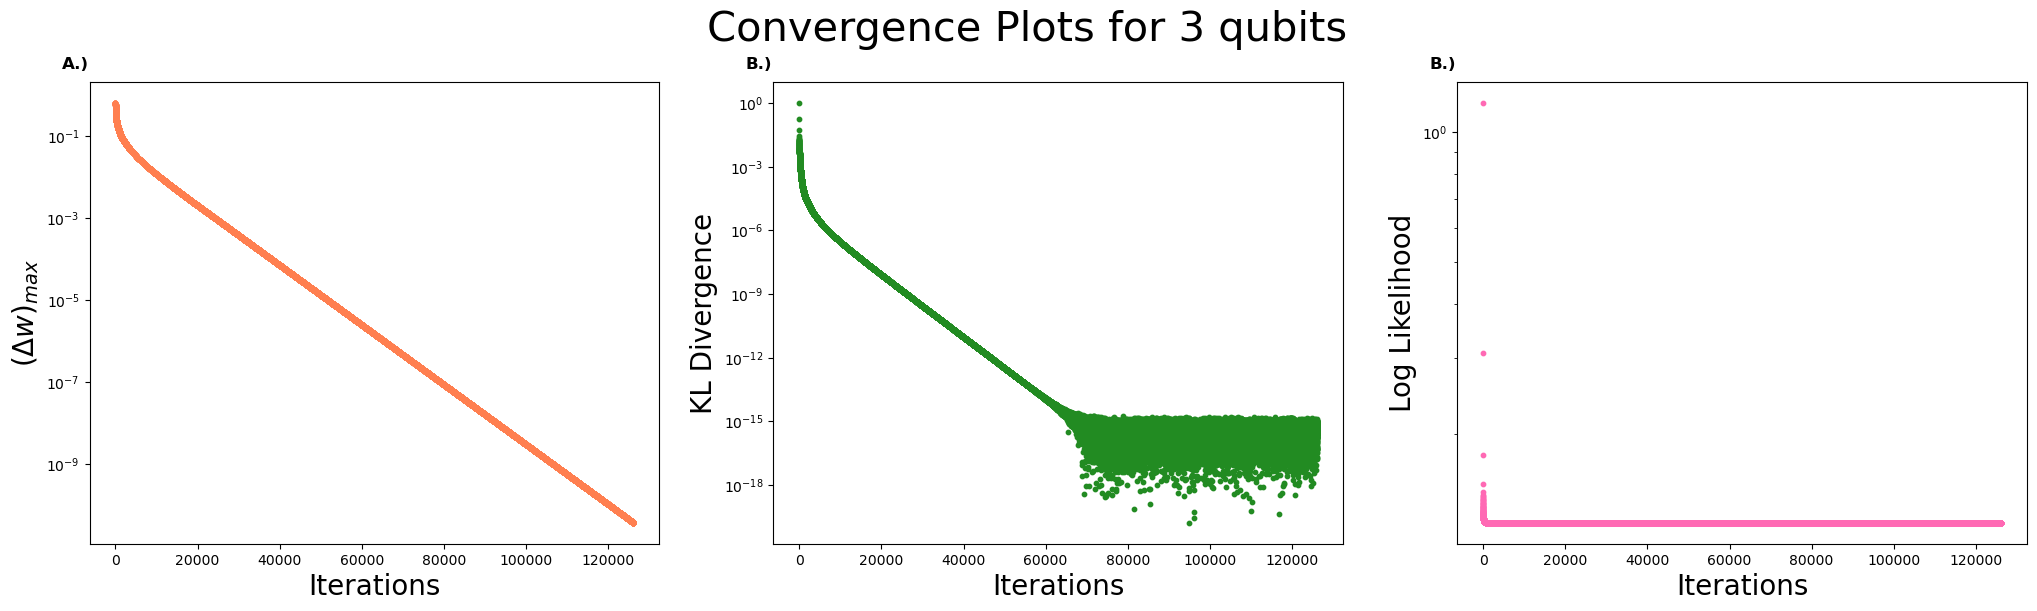

In [28]:
# 3-Qubit system parameters
num_qubits = 3
random_seed = 555

# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to each of the 16 possible interactions
w_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(w_oracle, interaction_matrices)
# learning parameters
learning_rate = 0.6
maxiter = 2**18
tolerance = 1e-14

# set initial weights for QBM
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels)

# train the Quantum Boltzmann Machine to recover the oracle interaction weights
w_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta, w_eta = w_oracle)

# print the recovered interaction weights and the oracle interaction weights for comparison
np.set_printoptions(precision=2, suppress=True)
print("Oracle Weights: \n", w_oracle)
print("QBM Recovered Weights: \n", w_qbm)

plot(it, Wdiff, kl, lk, title='Convergence Plots for 3 qubits', size=10)
plt.savefig('Figures/N Qubit QBM/convergence_3qubits', bbox_inches='tight')

- The left graph shows the largest difference between the entries of the oracle weight matrix and the QBM weight matrix vs the amount of iterations (if no oracle weight matrix is provided, it will show the change largest change in w_qbm compared to the previous iteration)  
- The middle graph shows the KL divergence vs the amount of iterations  
- The right graph shows the log likelihood

## Connecting the the QM equilbrium Ising model and the classical Ising dynamics.

Connecting the classical and quantum domain entails writing a function that converts a transition matrix in a density matrix and vice versa. This can be achieved as follows:

get steady state from W or sqrt p from rho.

Classical data can be encoded in a density matrix, which can then be analyzed using quantum models. We can describe both the data and model distribution using density matrices: $q(s) \mapsto \hat{\eta}$ and $p(s) \mapsto \hat{\rho}$, respectively. Given the classical data $q(s)$ and the observed dynamics $W(s|s')$ of a system, a symmetric density matrix can be obtained as follows:
\begin{equation} 
A \equiv \frac{1}{\sqrt{q(s)}} W(s|s') \sqrt{q(s')}
\end{equation}
By normalizing this matrix, the target distribution $\eta$ can be obtained:
\begin{equation}
\hat \eta = \frac{\hat A}{Tr{\hat A}}
\end{equation}
This process ensures that $\hat\eta$ is a semi-definite positive Hermitian operator.

When the classical data is obtained from an equilibrium system, the data state can be obtained by taking the outer product of the wave function constructed from the data distribution $q(s)$:
\begin{equation} 
\eta = \ket{\psi}\bra{\psi} \hspace{1cm}
\psi(s)= \braket{s|\psi} = \sqrt{q(s)}e^{i\alpha{s}}
\end{equation}

In [29]:
### QBM <-> ISING DYNAMICS FUNCTIONS
#----------------------------------------------------------------------
# @njit
def transition_matrix_to_density_matrix(W):
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))
    
    A = inv_sqrt_p_diag @ W.T @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # add a scalar constant to all eigenvalues to make them non-negative (ensuring rho is positive semidefinite)
    min_eigval = np.min(np.real(np.linalg.eigvals(A)))
    if min_eigval < 0:
        A += (np.abs(min_eigval) + 1e-4) * np.eye(A.shape[0])

    #  normalize such that Tr[rho] = 1
    rho = A / np.real(np.trace(A))    
    rho = rho.astype(np.complex128) #make it complex    

    return rho

# @njit
def density_matrix_to_transition_matrix(rho):
    # obtain the steady-state distribution √p
    eigenvalues, eigenvectors = np.linalg.eigh(rho)
    sqrt_p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])

    # square the elements of the eigenvector and normalize to obtain the steady-state distribution
    p = sqrt_p**2
    p = p / np.sum(p)  # normalize

    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))

    # calculate the matrix A
    A = np.real(rho)

    # compute the transition matrix W 
    W = sqrt_p_diag @ A @ inv_sqrt_p_diag
    W = W.T #switch back to row normalized by transposing

    # normalize each row to ensure the sum of each row equals 1
    W_row_sum = W.sum(axis=1)
    for i in range(W.shape[0]):
        W[i, :] /= W_row_sum[i]

    return W


check for 2 qubits

### Testing

We check if the conversion is inversible and if the density matrix that is obtained from W is ergodic. This can be done in two different ways. The first one is a brute-force method which checks that for some power k of $\rho$, all entries of the density matrix are non-zero. The 2nd is more subtle. It checks if all single-spin flip transitions are allowed. If that's the case, then each state in phase space is reachable by the system.

In [172]:
### TEST FUNCTIONS
#----------------------------------------------------------------------
def check_inversiblity(W, rho):
    # test 1
    W_prime = density_matrix_to_transition_matrix(transition_matrix_to_density_matrix(W))
    np.testing.assert_array_almost_equal(W, W_prime, decimal=2, err_msg="Functions are not inverses. Failed in test 1.")

    # test 2
    rho_prime = transition_matrix_to_density_matrix(density_matrix_to_transition_matrix(rho))
    np.testing.assert_array_almost_equal(np.real(rho), np.real(rho_prime), decimal=2, err_msg="Functions are not inverses. Failed in test 2.")

def check_ergodicity(rho, K=10):
    """
    Check if the density matrix rho is ergodic by iteratively squaring
    the matrix up to K times and checking for non-zero entries.
    """
    for _ in range(K):
        if np.all(rho > 0):
            return

        # quadratic of the density matrix
        rho = rho @ rho

    print(rho)
    # if after K iterations, there are still zero components, the matrix is not ergodic.
    assert False, "Matrix is not ergodic after {} iterations".format(K)

def check_single_flip_ergodicity(rho, W, n_spins):
    """
    Check if the components of the density matrix rho that correspond to 
    the transitions of the transition matrix W involving single spin flips are non-zero.
    """
    n_states = 2 ** n_spins

    for from_idx in range(n_states):
        for i in range(n_spins):
            # calculate the index of the state with the ith spin flipped
            to_idx = from_idx ^ (1 << i)

            # if the transition corresponds to a single spin flip and the component in rho is zero, raise an error
            assert not (W[from_idx, to_idx] > 0 and rho[from_idx, to_idx] == 0), "Single flip ergodicity failed at indices {} and {}".format(from_idx, to_idx)


In [178]:
# initialize the classical parameters
N = 3
w = np.array([[1.,2.,4.],
              [2.,4.,1.],
              [4.,1.,4.]])
J = np.array([[2,4,2],
              [4,3,1],
              [2,1,2]])
h = np.array([0, 2, 0])

# make sure w are large enough for normalized probabilities
w = find_min_w(w, h, J, step_size = 1e-3, no_flip_prob = 0)

# compute W and its associated rho
W = compute_transition_matrix(w, h, J)
rho_from_W = transition_matrix_to_density_matrix(W)

# compute a rho from quantum parameters
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

interaction_weights[('X', 'I', 'I')] = .1   #hx1
interaction_weights[('Y', 'I', 'I')] = .1   #hy1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1

interaction_weights[('I', 'X', 'I')] = .1   #hx2
interaction_weights[('I', 'Y', 'I')] = .1   #hy2
interaction_weights[('I', 'Z', 'I')] = .1   #hz2

interaction_weights[('I', 'I', 'X')] = .1   #hx3
interaction_weights[('I', 'I', 'Y')] = .1   #hy3
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('X', 'X', 'I')] = .2   #Jxx12
interaction_weights[('I', 'X', 'X')] = .2   #Jxx23
interaction_weights[('X', 'I', 'X')] = .2   #Jxx13

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23

interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13

interaction_weights[('X', 'Y', 'I')] = .5   #Jxy12
interaction_weights[('I', 'X', 'Y')] = .5   #Jxy23
interaction_weights[('X', 'I', 'Y')] = .5   #Jxy13

interaction_weights[('Y', 'X', 'I')] = .6   #Jyx12
interaction_weights[('I', 'Y', 'X')] = .6   #Jyx23
interaction_weights[('Y', 'I', 'X')] = .6   #Jyx13

interaction_weights[('X', 'Z', 'I')] = .7   #Jxz12
interaction_weights[('I', 'X', 'Z')] = .7   #Jxz23
interaction_weights[('X', 'I', 'Z')] = .7   #Jxz13

interaction_weights[('Z', 'X', 'I')] = .7   #Jzx12
interaction_weights[('I', 'Z', 'X')] = .7   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .7   #Jzx13

interaction_weights[('Y', 'Z', 'I')] = 8   #Jyz12
interaction_weights[('I', 'Y', 'Z')] = 3   #Jyz23
interaction_weights[('Y', 'I', 'Z')] = 2   #Jyz13

interaction_weights[('Z', 'Y', 'I')] = 8   #Jzy12
interaction_weights[('I', 'Z', 'Y')] = 3   #Jzy23
interaction_weights[('Z', 'I', 'Y')] = 2   #Jzy13

w = weights_dict_to_array(interaction_labels, interaction_weights) 

interaction_matrices,interaction_labels,_ = generate_interaction_matrices(num_qubits)
rho = rho_model(w, interaction_matrices)
check_single_flip_ergodicity(rho_from_W, W, N)
check_ergodicity(rho_from_W)

rho_prime = transition_matrix_to_density_matrix(density_matrix_to_transition_matrix(rho))
print(np.real(rho - rho_prime))

check_inversiblity(W, rho)


print("Test passed!")

[[ 0.01  0.    0.    0.    0.   -0.   -0.    0.  ]
 [ 0.    0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.    0.   -0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.01  0.    0.   -0.  ]
 [-0.    0.    0.   -0.    0.   -0.   -0.   -0.  ]
 [-0.    0.    0.   -0.    0.   -0.   -0.   -0.  ]
 [ 0.    0.    0.   -0.   -0.   -0.   -0.   -0.02]]


AssertionError: 
Arrays are not almost equal to 2 decimals
Functions are not inverses. Failed in test 2.
Mismatched elements: 1 / 64 (1.56%)
Max absolute difference: 0.02
Max relative difference: 0.16
 x: array([[ 0.17,  0.01,  0.01,  0.  ,  0.01, -0.  , -0.  , -0.  ],
       [ 0.01,  0.14,  0.  ,  0.01,  0.  ,  0.01,  0.  , -0.  ],
       [ 0.01,  0.  ,  0.14,  0.01,  0.  ,  0.  ,  0.01, -0.  ],...
 y: array([[ 0.15,  0.01,  0.01,  0.  ,  0.01, -0.  , -0.  , -0.  ],
       [ 0.01,  0.13,  0.  ,  0.01,  0.  ,  0.01,  0.  , -0.  ],
       [ 0.01,  0.  ,  0.13,  0.01,  0.  ,  0.  ,  0.01, -0.  ],...

## Quantum-Classical Mapping

We now got all the tools required for performing the QM-classical mapping. 

### Building the pipelines

We can build a pipeline forward_mapping() for which we get input classical parameters and output qm parameters:

We can also do the opposite, map qm parameters to classical ones. We call this the inverse route. inverse_mapping()

An obvious thing to check is if these pipelines are each others inverse:

### Plotting the mappings

forward_mapping_plot
inverse_mapping_plot

THINGS TO CHECK:
- Homogenous systems first [all the same]
- biases <-> sigma z
- Make a way to systematically review the change in parameters. Plots of the change in parameters versus the change in an other


In [ ]:
num_qubits = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

interaction_weights[('I', 'I')] = None
interaction_weights[('I', 'X')] = .1   #hx1
interaction_weights[('I', 'Y')] = .1   #hy1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('X', 'I')] = .1   #hx2
interaction_weights[('Y', 'I')] = .1   #hy2
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('X', 'X')] = .6   #Jxx
interaction_weights[('Y', 'Y')] = .5   #Jyy
interaction_weights[('Z', 'Z')] = .4   #Jzz

w = weights_dict_to_array(interaction_labels, interaction_weights) 


In [ ]:
# compute a rho from quantum parameters
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

interaction_weights[('X', 'I', 'I')] = .1   #hx1
interaction_weights[('Y', 'I', 'I')] = .1   #hy1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1

interaction_weights[('I', 'X', 'I')] = .1   #hx2
interaction_weights[('I', 'Y', 'I')] = .1   #hy2
interaction_weights[('I', 'Z', 'I')] = .1   #hz2

interaction_weights[('I', 'I', 'X')] = .1   #hx3
interaction_weights[('I', 'I', 'Y')] = .1   #hy3
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('X', 'X', 'I')] = .2   #Jxx12
interaction_weights[('I', 'X', 'X')] = .2   #Jxx23
interaction_weights[('X', 'I', 'X')] = .2   #Jxx13

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23

interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13

interaction_weights[('X', 'Y', 'I')] = .5   #Jxy12
interaction_weights[('I', 'X', 'Y')] = .5   #Jxy23
interaction_weights[('X', 'I', 'Y')] = .5   #Jxy13

interaction_weights[('Y', 'X', 'I')] = .6   #Jyx12
interaction_weights[('I', 'Y', 'X')] = .6   #Jyx23
interaction_weights[('Y', 'I', 'X')] = .6   #Jyx13

interaction_weights[('X', 'Z', 'I')] = .7   #Jxz12
interaction_weights[('I', 'X', 'Z')] = .7   #Jxz23
interaction_weights[('X', 'I', 'Z')] = .7   #Jxz13

interaction_weights[('Z', 'X', 'I')] = .7   #Jzx12
interaction_weights[('I', 'Z', 'X')] = .7   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .7   #Jzx13

interaction_weights[('Y', 'Z', 'I')] = 8   #Jyz12
interaction_weights[('I', 'Y', 'Z')] = 3   #Jyz23
interaction_weights[('Y', 'I', 'Z')] = 2   #Jyz13

interaction_weights[('Z', 'Y', 'I')] = 8   #Jzy12
interaction_weights[('I', 'Z', 'Y')] = 3   #Jzy23
interaction_weights[('Z', 'I', 'Y')] = 2   #Jzy13